In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox, jarque_bera, probplot
from scipy.special import inv_boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from pmdarima import auto_arima

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - Model Tuning

### Extracting the data

In [2]:
# Import full dataframe

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

# Select data for the time period, particles and stations of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

stations_of_interest = [28079004, 28079008, 28079011, 28079016, 28079017, 28079018, 
                        28079024, 28079035, 28079036, 28079038, 28079039, 28079040]

df_temp = df_full.loc[first_date:last_date][particles_of_interest + ['station']].sort_index()
df_temp = df_temp.loc[df_temp['station'].isin(stations_of_interest)]

print(f'The time period is from {first_date} to {last_date}')
print('')

# Generate dataframe for one particle and one station of interest

particle_of_interest = 'NO_2'
station_of_interest = 28079008

print(f'The particle of interest is: {particle_of_interest}')
print('')

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation = oneparticle_onestation.drop(columns = [x for x in particles_of_interest if x is not particle_of_interest], axis=1)
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')
oneparticle_onestation.dropna(inplace=True)

oneparticle_onestation['diff_particle'] = oneparticle_onestation[particle_of_interest].diff()
oneparticle_onestation['bc_particle'], lamb = boxcox(oneparticle_onestation[particle_of_interest])
oneparticle_onestation['bc_diff_particle'] = oneparticle_onestation['bc_particle'].diff()
oneparticle_onestation.fillna(0, inplace=True)

oneparticle_onestation['quarter'] = oneparticle_onestation.index.quarter
oneparticle_onestation['dayofyear'] = oneparticle_onestation.index.dayofyear
oneparticle_onestation['dayofmonth'] = oneparticle_onestation.index.day
oneparticle_onestation['weekyear'] = oneparticle_onestation.index.weekofyear
oneparticle_onestation['weekday'] = oneparticle_onestation.index.weekday
oneparticle_onestation['hour'] = oneparticle_onestation.index.hour
oneparticle_onestation['year'] = oneparticle_onestation.index.year
oneparticle_onestation['month'] = oneparticle_onestation.index.month
oneparticle_onestation.fillna(0, inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
oneparticle_onestation.head()

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

The particle of interest is: NO_2

The station of interest is: 28079008

Missing values for particle and station of interest: 1.17%

One particle, one station DF shape: (54841, 12)


,NO_2,diff_particle,bc_particle,bc_diff_particle,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,,,,
2012-01-01 00:00:00,97.0,0.0,7.645953,0.000000,1,1,1,52,6,0,2012,1
2012-01-01 01:00:00,114.0,17.0,8.071571,0.425619,1,1,1,52,6,1,2012,1
2012-01-01 02:00:00,120.0,6.0,8.209782,0.138211,1,1,1,52,6,2,2012,1
2012-01-01 03:00:00,106.0,-14.0,7.878034,-0.331748,1,1,1,52,6,3,2012,1
2012-01-01 04:00:00,71.0,-35.0,6.863006,-1.015028,1,1,1,52,6,4,2012,1


In [3]:
# Define train, test split 

num_weeks = 1
test_size = 24 * 7 * num_weeks 
train_size = len(oneparticle_onestation[particle_of_interest])-(test_size)
train, test = oneparticle_onestation[:train_size], oneparticle_onestation[train_size:]
    
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print('Test proportion (percent): %.2f' % (len(test) / len(oneparticle_onestation) * 100))

Train shape: (54673, 12)
Test shape: (168, 12)
Test proportion (percent): 0.31


In [4]:
# Define function to revert transformations

def revert_predictions(train, predictions):
    predictions_cumsum = predictions.cumsum()
    predictions_inv_bc = inv_boxcox(predictions_cumsum, lamb)
    predictions_final = train[particle_of_interest][-1] + predictions_inv_bc
    return predictions_final

# Define function to plot actuals vs predictions

def plot_actuals_predictions(predictions_final):
    fig, ax = plt.subplots(figsize=(21,7))
    actuals = plt.plot(test[particle_of_interest], label='Actuals')
    predictions = plt.plot(predictions_final, label='Predictions')
    error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    plt.legend(loc='best')
    plt.title('RMSE: %.2f'% error)
    plt.show()
    
# Define model evaluation function

def evaluate_forecast(predictions_final, model_name):
    results = pd.DataFrame({'models': model_name,
                           }, index=[0])
    results['r2_score'] = r2_score(test[particle_of_interest], predictions_final)
    results['mean_abs_error'] = mean_absolute_error(test[particle_of_interest], predictions_final)
    results['median_abs_error'] = median_absolute_error(test[particle_of_interest], predictions_final)
    results['mse'] = mean_squared_error(test[particle_of_interest], predictions_final)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Define model validation function

def model_diagnostics(residuals, model_fit):
    godfrey = acorr_breusch_godfrey(model_fit, nlags= 40)
    j_bera = jarque_bera(residuals)

    print('Results of Breusch-Godfrey:')
    print('Null Hypothesis: No auotcorrelation')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-values: {godfrey[1]}\n')
    print('Results of Jarque-Bera:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {j_bera[1]}')
    
# Define plot diagnostics function

def plot_diagnostics(residuals):
    residuals.plot(title='ARIMA Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('ARIMA Residuals KDE')
    ax[1].set_title('ARIMA Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(residuals, dist='norm', plot=ax[1])
    plt.show()  

### Auto ARIMA

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=75738.855, BIC=75792.309, Time=93.127 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=91527.755, BIC=91545.574, Time=6.861 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=84198.110, BIC=84224.838, Time=3.569 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=84479.179, BIC=84505.907, Time=6.990 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=91525.756, BIC=91534.665, Time=1.030 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=83866.499, BIC=83911.045, Time=27.861 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=76437.933, BIC=76482.479, Time=75.115 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=76396.496, BIC=76458.860, Time=91.000 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=75703.064, BIC=75765.428, Time=139.030 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True);

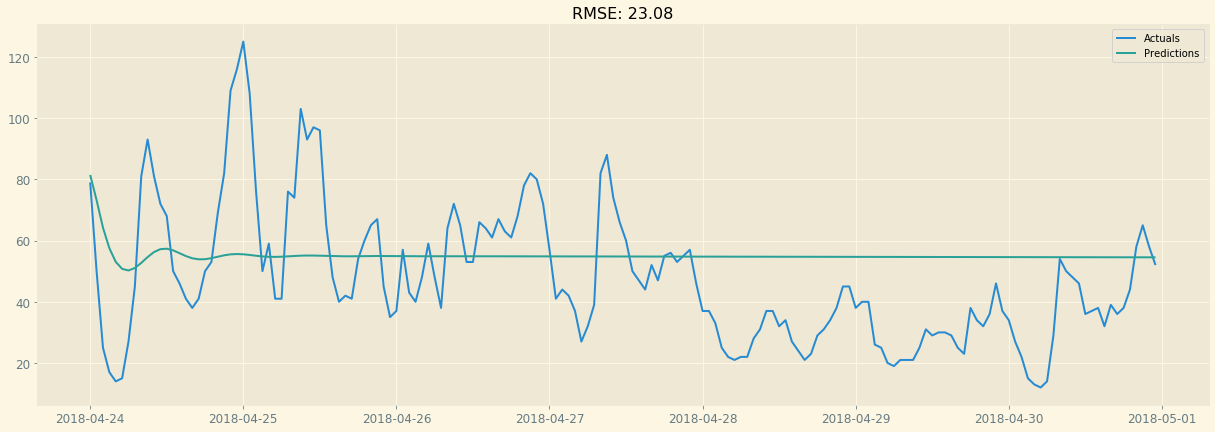

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse
0,Auto ARIMA: bc_particle,-0.093783,19.169096,17.35902,532.902866,23.084689


In [5]:
model_name = 'Auto ARIMA: bc_particle'

# 1. Instantiate and fit model

model = auto_arima(train['bc_particle'], trace=True, error_action='ignore', suppress_warnings=True) 
model_fit = model.fit(train['bc_particle'], disp=-1)
print(model_fit.summary())

# 2. Generate predictions

predictions = model_fit.predict(n_periods=len(test))
predictions = pd.Series(predictions, index=test.index)
predictions_final = inv_boxcox(predictions, lamb)

# 3. Plot actuals vs predictions

fig, ax = plt.subplots(figsize=(21,7))

actuals = plt.plot(test[particle_of_interest], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()

# 4. Evaluate the model

results = evaluate_forecast(predictions_final, model_name)
results

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=75740.367, BIC=75793.822, Time=89.625 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=91528.430, BIC=91546.248, Time=6.284 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=84198.733, BIC=84225.461, Time=3.489 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=84479.784, BIC=84506.511, Time=5.698 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=91526.430, BIC=91535.339, Time=2.402 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=83867.117, BIC=83911.663, Time=23.346 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=76439.156, BIC=76483.701, Time=45.928 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=76397.804, BIC=76460.168, Time=111.433 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=75717.357, BIC=75779.720, Time=98.089 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True);

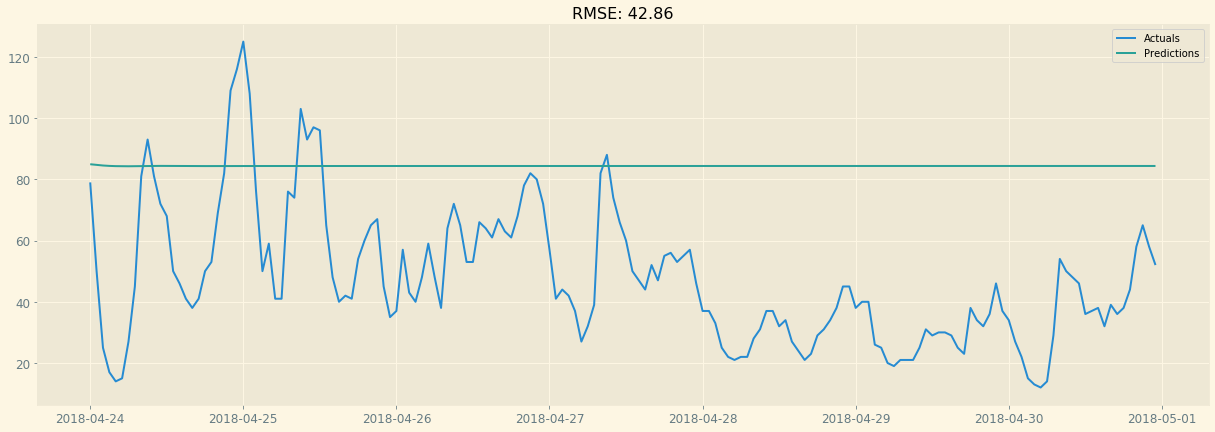

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse
0,Auto ARIMA: bc_particle,-0.093783,19.169096,17.359020,532.902866,23.084689
0,Auto ARIMA: bc_diff_particle,-2.769928,38.934043,40.996413,1836.748712,42.857306


In [6]:
model_name = 'Auto ARIMA: bc_diff_particle'

# 1. Instantiate and fit model

model = auto_arima(train['bc_diff_particle'], trace=True, error_action='ignore', suppress_warnings=True) 
model_fit = model.fit(train['bc_diff_particle'], disp=-1)
print(model_fit.summary())

# 2. Generate predictions

predictions = model_fit.predict(n_periods=len(test))
predictions = pd.Series(predictions, index=test.index)
predictions_final = revert_predictions(train, predictions)

# 3. Plot actuals vs predictions

fig, ax = plt.subplots(figsize=(21,7))

actuals = plt.plot(test[particle_of_interest], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()

# 4. Evaluate the model

results = results.append(evaluate_forecast(predictions_final, model_name))
results

### Auto - SARIMA

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=72616.334, BIC=72687.607, Time=595.677 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=91527.755, BIC=91545.574, Time=10.787 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=83408.842, BIC=83444.479, Time=64.140 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=83850.812, BIC=83886.448, Time=53.681 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=91525.756, BIC=91534.665, Time=1.381 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 1, 12) (constant=True); AIC=75687.395, BIC=75749.759, Time=513.610 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 0, 12) (constant=True); AIC=75652.655, BIC=75715.019, Time=552.101 seconds
Fit ARIMA: (2, 1, 2)x(2, 0, 1, 12) (constant=True); AIC=73733.483, BIC=73813.665, Time=1253.900 seconds
Near non-invertible roots for order (2, 1, 2)(2, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of t

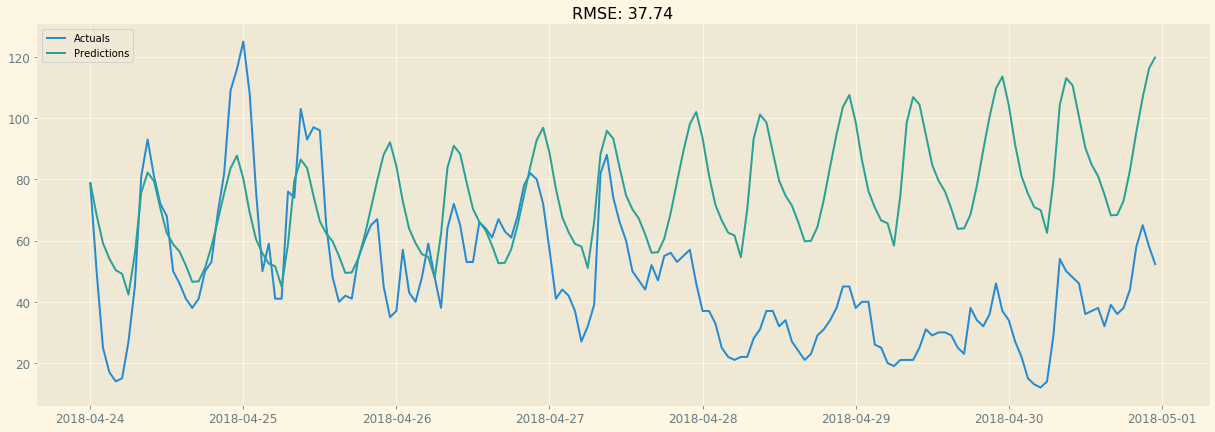

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse
0,Auto ARIMA: bc_particle,-0.093783,19.169096,17.359020,532.902866,23.084689
0,Auto ARIMA: bc_diff_particle,-2.769928,38.934043,40.996413,1836.748712,42.857306
0,Auto SARIMA: bc_particle,-1.923727,31.099324,31.353438,1424.470578,37.742159


In [7]:
model_name = 'Auto SARIMA: bc_particle'

# 1. Instantiate and fit model

model = auto_arima(train['bc_particle'], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12, stepwise=True) 
model_fit = model.fit(train['bc_particle'], disp=-1)
print(model_fit.summary())

# 2. Generate predictions

predictions = model_fit.predict(n_periods=len(test))
predictions = pd.Series(predictions, index=test.index)
predictions_final = inv_boxcox(predictions, lamb)

# 3. Plot actuals vs predictions

fig, ax = plt.subplots(figsize=(21,7))

actuals = plt.plot(test[particle_of_interest], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()

# 4. Evaluate the model

results = results.append(evaluate_forecast(predictions_final, model_name))
results

In [ ]:
model_name = 'Auto SARIMA: bc_diff_particle'

# 1. Instantiate and fit model

model = auto_arima(train['bc_diff_particle'], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12, stepwise=True) 
model_fit = model.fit(train['bc_diff_particle'], disp=-1)
print(model_fit.summary())

# 2. Generate predictions

predictions = model_fit.predict(n_periods=len(test))
predictions = pd.Series(predictions, index=test.index)
predictions_final = revert_predictions(train, predictions)

# 3. Plot actuals vs predictions

fig, ax = plt.subplots(figsize=(21,7))

actuals = plt.plot(test[particle_of_interest], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()

# 4. Evaluate the model



Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=72798.457, BIC=72869.730, Time=347.508 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=91528.430, BIC=91546.248, Time=6.320 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=83409.402, BIC=83445.039, Time=29.330 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=83851.375, BIC=83887.012, Time=24.378 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=91526.430, BIC=91535.339, Time=2.924 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 1, 12) (constant=True); AIC=75687.318, BIC=75749.682, Time=303.755 seconds
Fit ARIMA: (2, 0, 2)x(1, 0, 0, 12) (constant=True); AIC=75917.567, BIC=75979.930, Time=236.799 seconds
Fit ARIMA: (2, 0, 2)x(2, 0, 1, 12) (constant=True); AIC=73905.641, BIC=73985.823, Time=844.339 seconds
Near non-invertible roots for order (2, 0, 2)(2, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the

In [ ]:
results_autoSARIMA_diff = evaluate_forecast(predictions_final, model_name)
results_autoSARIMA_diff

### Grid search ARIMA

In [ ]:
from collections import defaultdict

# 0. Define function to evaluate model

def evaluate_model(train, test, target, pdq):
    test_len = len(test)
    model = ARIMA(train[target], order=pdq)
    model_fit = model.fit(disp=-1)
    predictions = model_fit.forecast(test_len)
    aic = model_fit.aic
    mse = mean_squared_error(test[target], predictions[0])
    rmse = sqrt(mse)
    return {'rmse': rmse, 'aic': aic}

# 1. Define grid to iterate over

p = range(0, 12)
d = range(0, 2)
q = range(0, 12)

pdq = list(itertools.product(p, d, q))

# 2. Find combination of paraters that minimizes the AIC for 

models = defaultdict()
target = 'bc_particle'

for params in pdq:
    try:
        score = evaluate_model(train, test, particle_of_interest, params)
        models[str(params)] = score['order']
        if score['aic'] < best_score:
            best_score, best_params = score['aic'], params
    except:
        continue
            
# 3. Fit a model with the best parameters and generate predictions

best_parameters = best_params
model = ARIMA(train[target], order=best_parameters)
model_fit = model.fit(disp=-1)

test_len = len(test)
prediction = model_fit.forecast(test_len)

predictions_final = pd.DataFrame(prediction[0], index= test.index)

# 4. Plot actuals vs predictions

fig, ax = plt.subplots(figsize=(21,7))

actuals = plt.plot(test[particle_of_interest], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()

# 5. Evaluate the model

results = results.append(evaluate_forecast(predictions_final, model_name))
results

In [ ]:
# Get Top 5 parameters and scores ranked by AIC 

sorted_scores_ARIMA = sorted(models.items(), key = lambda x:x[1]['aic'])

print('Best ARIMA Parameters and Scores Ranked By AIC')
for i in range(5):
    print(f'{sorted_scores[i][0]}, {sorted_scores[i][1]}')

In [ ]:
# Run model diagnosticts and plot residuals

resid = model_fit.resid

model_diagnostics(resid, model_fit)
plot_diagnostics(resid)